Import Library

In [1]:
import os
import pandas as pd
import numpy as np

import seaborn as sns

import cv2
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

Data Preparation

In [2]:
# mount Google Drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
# Dataset path
DATASET = '/content/gdrive/MyDrive/IndonesiaAI/Project 1 - Face Recognition/Dataset'

In [4]:
#DATASET_IMG = os.listdir(os.path.join(DATASET,'Images'))
#ATTR_PATH = "./list_attr_celeba.csv"

In [5]:
DATASET_IMG = DATASET + "//" + "Dataset/Images"
ATTR_PATH = DATASET + "//" + "list_attr_celeba.csv"

In [6]:
data_attr = pd.read_csv(ATTR_PATH)
data_attr.head()

,image_id,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [7]:
df_gender = data_attr.loc[:, ["image_id", "Male"]]
df_gender.head()

,image_id,Male
0,000001.jpg,-1
1,000002.jpg,-1
2,000003.jpg,1
3,000004.jpg,-1
4,000005.jpg,-1


In [8]:
df_gender.replace(-1,0,inplace=True)

In [10]:
df_gender.head()

,image_id,Male
0,000001.jpg,0
1,000002.jpg,0
2,000003.jpg,1
3,000004.jpg,0
4,000005.jpg,0


In [13]:
image = set(os.listdir(DATASET_IMG))
DATASET_TARGET = df_gender[df_gender['image_id'].isin(image)]

In [14]:
DATASET_TARGET.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5000 entries, 50 to 202565
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   image_id  5000 non-null   object
 1   Male      5000 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 117.2+ KB


In [15]:
DATASET_TARGET.head()

,image_id,Male
50,000051.jpg,1
51,000052.jpg,1
64,000065.jpg,1
165,000166.jpg,1
197,000198.jpg,0


In [16]:
DATASET_TARGET['Male'].value_counts()

0    2953
1    2047
Name: Male, dtype: int64

Handling Unbalanced Data

In [17]:
def undersampling (df_gender, target):
    #Mendapatkan jumlah tiap kelas
    class_counts = df_gender[target].value_counts()

    #Mencari minoritas kelas
    minority_class = class_counts.idxmin()

    #Mendapatkan jumlah sampling didalam minoritas kelas
    minority_class_count = class_counts[minority_class]

    #Mendapatkan indikasi pada kelas mayoritas
    majority_class_indices = df_gender[df_gender[target] != minority_class].index

    #Random over sampling augmented
    undersampled_majority_indices = df_gender[df_gender[target] == minority_class].index.union(
        df_gender.loc[majority_class_indices].sample(n=minority_class_count, random_state=42).index
                                                                                             )
    #Membuat balanced dataset
    balanced_df = df_gender.loc[undersampled_majority_indices]

    #Your balanced dataset
    print(balanced_df[target].value_counts())

    return balanced_df

In [18]:
DATASET_TARGET = undersampling(DATASET_TARGET,'Male')

1    2047
0    2047
Name: Male, dtype: int64


Split Data

In [19]:
from sklearn.model_selection import train_test_split

In [20]:
train_data, test_data = train_test_split(DATASET_TARGET, random_state=88, test_size=0.2, stratify = DATASET_TARGET['Male'])

In [21]:
train_data['Male'] = train_data['Male'].astype(str)
test_data['Male'] = test_data['Male'].astype(str)

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [23]:
# Define image dimensions and batch size
image_size = (218, 178)
batch_size = 32

# Create a data generator
datagen = ImageDataGenerator(
    rescale=1.0 / 255,  # Normalize pixel values
    rotation_range=20,  # Data augmentation options (adjust as needed)
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.2
)

train_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=DATASET_IMG,
    x_col='image_id',
    y_col='Male',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
    shuffle=True  # Shuffle the training data
)

validation_generator = datagen.flow_from_dataframe(
    dataframe=train_data,
    directory=DATASET_IMG,
    x_col='image_id',
    y_col='Male',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    subset='validation',
)

test_generator = datagen.flow_from_dataframe(
    dataframe=test_data,
    directory=DATASET_IMG,
    x_col='image_id',
    y_col='Male',
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False  # Don't shuffle the test data
)

Found 2620 validated image filenames belonging to 2 classes.
Found 655 validated image filenames belonging to 2 classes.
Found 819 validated image filenames belonging to 2 classes.


Training

In [26]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Load the InceptionV1 model from TensorFlow Hub with ImageNet weights
hub_model_url = "https://tfhub.dev/google/imagenet/inception_v1/classification/4"
base_model_googleNet = hub.KerasLayer(hub_model_url, trainable=False)

# Create a custom top model for binary classification
model_googleNet = tf.keras.Sequential([
    base_model_googleNet,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_googleNet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
history5 = model_googleNet.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
82/82 [==============================] - 968s 12s/step - loss: 0.4582 - accuracy: 0.8046 - val_loss: 0.3299 - val_accuracy: 0.8565
Epoch 2/10
82/82 [==============================] - 199s 2s/step - loss: 0.3155 - accuracy: 0.8721 - val_loss: 0.3295 - val_accuracy: 0.8656
Epoch 3/10
82/82 [==============================] - 197s 2s/step - loss: 0.2899 - accuracy: 0.8756 - val_loss: 0.3006 - val_accuracy: 0.8702
Epoch 4/10
82/82 [==============================] - 197s 2s/step - loss: 0.2687 - accuracy: 0.8851 - val_loss: 0.3120 - val_accuracy: 0.8718
Epoch 5/10
82/82 [==============================] - 195s 2s/step - loss: 0.2732 - accuracy: 0.8889 - val_loss: 0.2986 - val_accuracy: 0.8672
Epoch 6/10
82/82 [==============================] - 197s 2s/step - loss: 0.2417 - accuracy: 0.9004 - val_loss: 0.2999 - val_accuracy: 0.8809
Epoch 7/10
82/82 [==============================] - 197s 2s/step - loss: 0.2331 - accuracy: 0.9046 - val_loss: 0.3203 - val_accuracy: 0.8656
Epoch 8/10
8

In [ ]:
# Define a function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

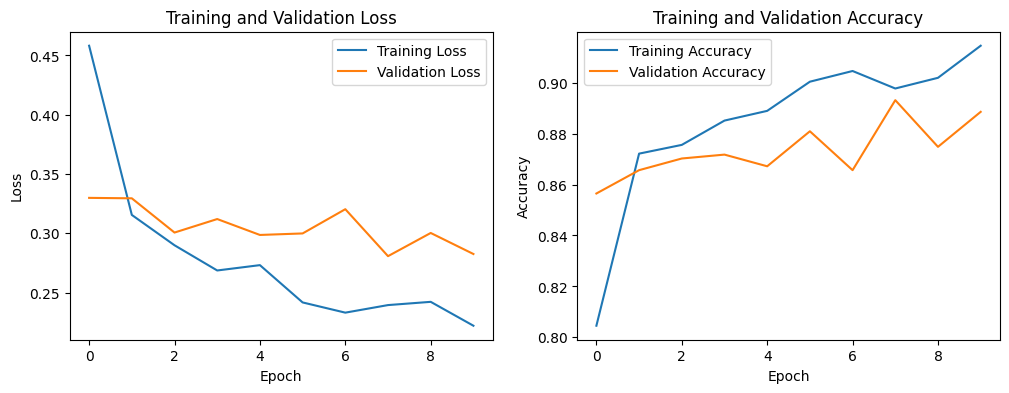

In [ ]:
# GoogleNet
plot_training_history(history5)

Train 2

In [34]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Load the InceptionV1 model from TensorFlow Hub with ImageNet weights
hub_model_url = "https://tfhub.dev/google/imagenet/inception_v1/classification/4"
base_model_googleNet = hub.KerasLayer(hub_model_url, trainable=False)

# Create a custom top model for binary classification
model_googleNet = tf.keras.Sequential([
    base_model_googleNet,
    Flatten(),
    Dense(256, activation='tanh'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_googleNet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [35]:
# Train the model
history6 = model_googleNet.fit(train_generator, epochs=10, validation_data=validation_generator)

Epoch 1/10
82/82 [==============================] - 327s 4s/step - loss: 0.3967 - accuracy: 0.8298 - val_loss: 0.3133 - val_accuracy: 0.8672
Epoch 2/10
82/82 [==============================] - 256s 3s/step - loss: 0.2999 - accuracy: 0.8802 - val_loss: 0.3046 - val_accuracy: 0.8733
Epoch 3/10
82/82 [==============================] - 259s 3s/step - loss: 0.2949 - accuracy: 0.8821 - val_loss: 0.2929 - val_accuracy: 0.8794
Epoch 4/10
82/82 [==============================] - 256s 3s/step - loss: 0.2764 - accuracy: 0.8893 - val_loss: 0.3197 - val_accuracy: 0.8748
Epoch 5/10
82/82 [==============================] - 259s 3s/step - loss: 0.2554 - accuracy: 0.8996 - val_loss: 0.3170 - val_accuracy: 0.8672
Epoch 6/10
82/82 [==============================] - 256s 3s/step - loss: 0.2665 - accuracy: 0.8870 - val_loss: 0.2866 - val_accuracy: 0.8870
Epoch 7/10
82/82 [==============================] - 256s 3s/step - loss: 0.2744 - accuracy: 0.8901 - val_loss: 0.2801 - val_accuracy: 0.8885
Epoch 8/10
82

Training 3

In [36]:
import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from tensorflow.keras.optimizers import Adam

# Load the InceptionV1 model from TensorFlow Hub with ImageNet weights
hub_model_url = "https://tfhub.dev/google/imagenet/inception_v1/classification/4"
base_model_googleNet = hub.KerasLayer(hub_model_url, trainable=False)

# Create a custom top model for binary classification
model_googleNet = tf.keras.Sequential([
    base_model_googleNet,
    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model_googleNet.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

In [37]:
# Train the model
history5 = model_googleNet.fit(train_generator, epochs=20, validation_data=validation_generator)

Epoch 1/20
82/82 [==============================] - 266s 3s/step - loss: 0.5614 - accuracy: 0.7702 - val_loss: 0.3097 - val_accuracy: 0.8748
Epoch 2/20
82/82 [==============================] - 258s 3s/step - loss: 0.3416 - accuracy: 0.8660 - val_loss: 0.3298 - val_accuracy: 0.8718
Epoch 3/20
82/82 [==============================] - 221s 3s/step - loss: 0.3023 - accuracy: 0.8794 - val_loss: 0.3048 - val_accuracy: 0.8916
Epoch 4/20
82/82 [==============================] - 259s 3s/step - loss: 0.2723 - accuracy: 0.8863 - val_loss: 0.3185 - val_accuracy: 0.8611
Epoch 5/20
82/82 [==============================] - 256s 3s/step - loss: 0.2676 - accuracy: 0.8863 - val_loss: 0.2952 - val_accuracy: 0.8687
Epoch 6/20
82/82 [==============================] - 259s 3s/step - loss: 0.2614 - accuracy: 0.8893 - val_loss: 0.3056 - val_accuracy: 0.8763
Epoch 7/20
82/82 [==============================] - 260s 3s/step - loss: 0.2384 - accuracy: 0.8992 - val_loss: 0.2762 - val_accuracy: 0.8870
Epoch 8/20
82